<a href="https://colab.research.google.com/github/mccoymb/AAE-590-DSMM/blob/main/590DSMM_HW3_FoundData_Corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

time_values = np.array([25000, 28000, 31000, 35000, 37500, 40000, 45000, 50000, 75000, 108000,
                        180000, 220000, 250000, 270000, 300000, 360000, 430000, 540000, 900000, 1080000])

In [ ]:
data = np.load('/home/mccoymb/Downloads/train.npz')

print("Keys in npz file:", data.files)
input_raw_data = data['input_raw_data']  # Shape: (200000, 1, 64, 64)

Keys in npz file: ['clips', 'dims', 'input_raw_data']


In [ ]:
num_sequences = 200
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

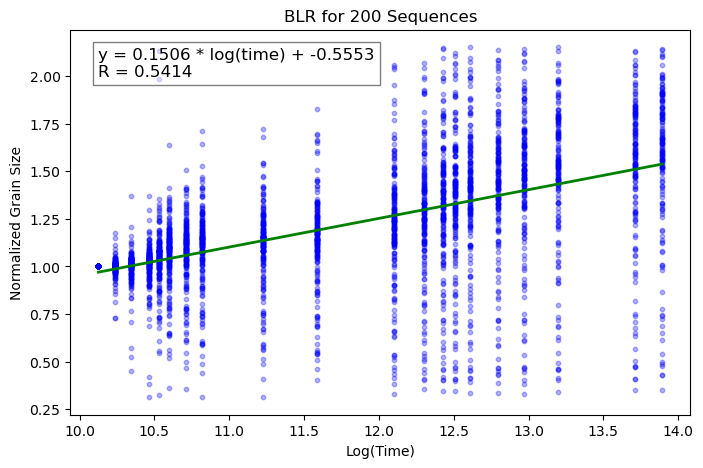

Regression Equation: y = 0.1506 * log(time) + -0.5553
R = 0.5414


In [ ]:
from sklearn.linear_model import BayesianRidge

# Train Bayesian Linear Regression
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = bayesian_ridge.coef_[0]
intercept = bayesian_ridge.intercept_

# Predict and calculate R-value
predicted_grain_sizes = bayesian_ridge.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), bayesian_ridge.predict(np.log(time_values).reshape(-1, 1)),
         label="Bayesian Regression Fit", color="green", linewidth=2)

# Add equation text to the plot
plt.text(min(X_filtered), max(Y_filtered), equation, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.title("BLR for 200 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


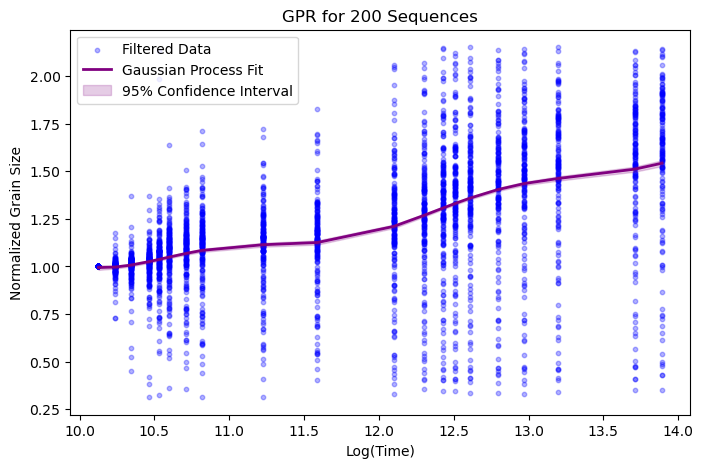

Gaussian Process Regression R-Value: 0.5414


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define kernel: Combination of a constant term and RBF kernel
kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

# Train Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01)
gpr.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Predict with uncertainty estimates
predicted_grain_sizes, sigma = gpr.predict(np.log(time_values).reshape(-1, 1), return_std=True)


# Plot results with uncertainty
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), predicted_grain_sizes, label="Gaussian Process Fit", color="purple", linewidth=2)

# Plot confidence interval
plt.fill_between(np.log(time_values), predicted_grain_sizes - 2 * sigma, predicted_grain_sizes + 2 * sigma,
                 color='purple', alpha=0.2, label="95% Confidence Interval")

plt.title("GPR for 200 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the R-value
print(f"Gaussian Process Regression R-Value: {r_value:.4f}")


In [ ]:
num_sequences = 100
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

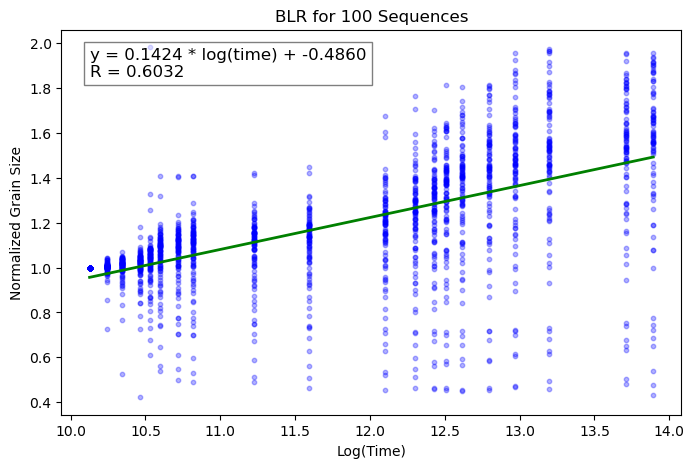

Regression Equation: y = 0.1424 * log(time) + -0.4860
R = 0.6032


In [ ]:
from sklearn.linear_model import BayesianRidge

# Train Bayesian Linear Regression
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = bayesian_ridge.coef_[0]
intercept = bayesian_ridge.intercept_

# Predict and calculate R-value
predicted_grain_sizes = bayesian_ridge.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), bayesian_ridge.predict(np.log(time_values).reshape(-1, 1)),
         label="Bayesian Regression Fit", color="green", linewidth=2)

# Add equation text to the plot
plt.text(min(X_filtered), max(Y_filtered), equation, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.title("BLR for 100 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


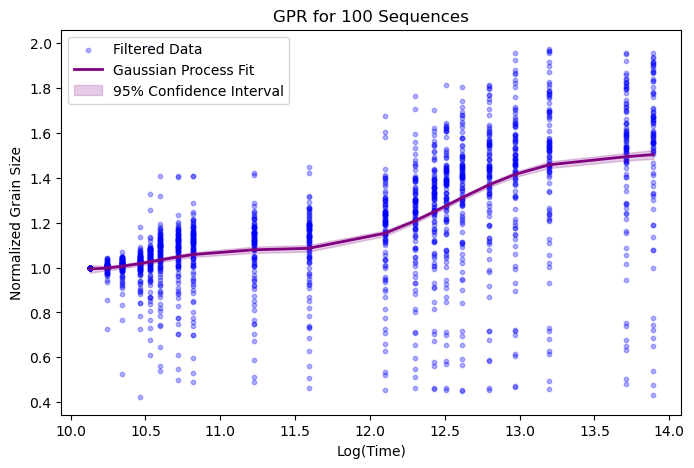

Gaussian Process Regression R-Value: 0.6032


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define kernel: Combination of a constant term and RBF kernel
kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

# Train Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01)
gpr.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Predict with uncertainty estimates
predicted_grain_sizes, sigma = gpr.predict(np.log(time_values).reshape(-1, 1), return_std=True)


# Plot results with uncertainty
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), predicted_grain_sizes, label="Gaussian Process Fit", color="purple", linewidth=2)

# Plot confidence interval
plt.fill_between(np.log(time_values), predicted_grain_sizes - 2 * sigma, predicted_grain_sizes + 2 * sigma,
                 color='purple', alpha=0.2, label="95% Confidence Interval")

plt.title("GPR for 100 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the R-value
print(f"Gaussian Process Regression R-Value: {r_value:.4f}")


In [ ]:
num_sequences = 10
subset_raw_data = input_raw_data[:num_sequences * 20]

# Function to compute grain size
def compute_grain_size(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]  # Ignore small artifacts
    return np.mean(areas) if areas else 1e-6  # Avoid division by zero

# Compute grain size for the selected sequences
all_grain_sizes = np.zeros((num_sequences, 20))

for seq in range(num_sequences):
    sequence_images = subset_raw_data[seq * 20:(seq + 1) * 20, 0, :, :]
    grain_sizes = np.array([compute_grain_size(img) for img in sequence_images])

    # Ensure first image has a reasonable minimum value
    first_grain_size = max(grain_sizes[0], 1)

    # Normalize each image by the first image in its sequence
    all_grain_sizes[seq] = grain_sizes / first_grain_size


X_log_time = np.tile(np.log(time_values), num_sequences)
Y_grain_sizes = all_grain_sizes.flatten()

# IQR
Q1 = np.percentile(Y_grain_sizes, 25)
Q3 = np.percentile(Y_grain_sizes, 75)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (Y_grain_sizes >= lower_bound) & (Y_grain_sizes <= upper_bound)
X_filtered = X_log_time[mask]
Y_filtered = Y_grain_sizes[mask]

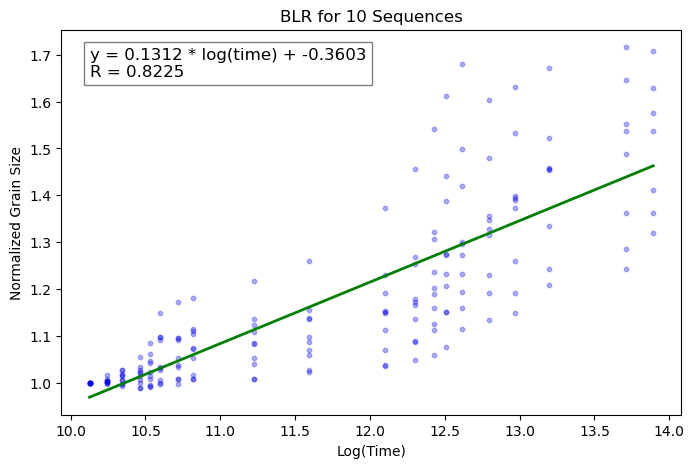

Regression Equation: y = 0.1312 * log(time) + -0.3603
R = 0.8225


In [ ]:
from sklearn.linear_model import BayesianRidge

# Train Bayesian Linear Regression
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Get regression coefficients
slope = bayesian_ridge.coef_[0]
intercept = bayesian_ridge.intercept_

# Predict and calculate R-value
predicted_grain_sizes = bayesian_ridge.predict(X_filtered.reshape(-1, 1))
r_value, _ = pearsonr(Y_filtered, predicted_grain_sizes)

# Display the regression equation
equation = f"y = {slope:.4f} * log(time) + {intercept:.4f}\nR = {r_value:.4f}"

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), bayesian_ridge.predict(np.log(time_values).reshape(-1, 1)),
         label="Bayesian Regression Fit", color="green", linewidth=2)

# Add equation text to the plot
plt.text(min(X_filtered), max(Y_filtered), equation, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.title("BLR for 10 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.show()

# Print the equation with R-value
print("Regression Equation:", equation)


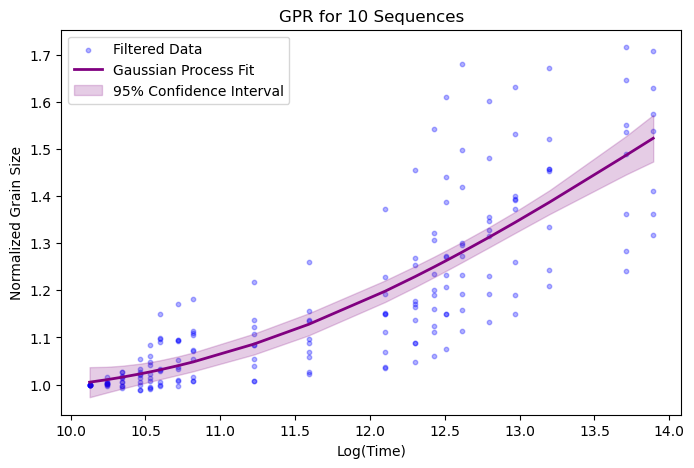

Gaussian Process Regression R-Value: 0.8225


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define kernel: Combination of a constant term and RBF kernel
kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

# Train Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01)
gpr.fit(X_filtered.reshape(-1, 1), Y_filtered)

# Predict with uncertainty estimates
predicted_grain_sizes, sigma = gpr.predict(np.log(time_values).reshape(-1, 1), return_std=True)


# Plot results with uncertainty
plt.figure(figsize=(8, 5))
plt.scatter(X_filtered, Y_filtered, label="Filtered Data", color="blue", alpha=0.3, s=10)
plt.plot(np.log(time_values), predicted_grain_sizes, label="Gaussian Process Fit", color="purple", linewidth=2)

# Plot confidence interval
plt.fill_between(np.log(time_values), predicted_grain_sizes - 2 * sigma, predicted_grain_sizes + 2 * sigma,
                 color='purple', alpha=0.2, label="95% Confidence Interval")

plt.title("GPR for 10 Sequences")
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain Size")
plt.legend()
plt.show()

# Print the R-value
print(f"Gaussian Process Regression R-Value: {r_value:.4f}")
